In [14]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import os 
from tqdm import tqdm

def read_image(filename, gray=False):
    im = cv2.imread(filename) 
    if gray: 
        im = gray(im)
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB) if im is not None else None

def show_images(col, row, images, titles=[], cmaps=[], scale=2):
    plt.figure(figsize=(row * scale, col * scale))
    titles = titles if titles else ["No Title" for i in range(len(images))]
    cmaps = cmaps if cmaps else [0 for i in images]
    for i in range(len(images)):
        plt.subplot(col, row, i + 1)
        if cmaps[i]: 
            plt.imshow(images[i])
        else:
            plt.imshow(images[i], cmap="gray")
        plt.title(titles[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def negative(img):
    return 255 - img

def invert(img):
    return cv2.bitwise_not(img)

def threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU):
    _, bw_img = cv2.threshold(img, thresh, maxval, type=type)
    return bw_img

def dilate(img, kernel_size=3, iterations=3):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated_img = cv2.dilate(img, kernel, anchor=(-1, -1), iterations=iterations)
    return dilated_img

def erode(img, kernel_size=3, iterations=4):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    erod_img = cv2.erode(img, kernel, anchor=(-1, -1), iterations=iterations)
    return erod_img

def process_image(img, effects, titles=[], verbose=True, col=1, row=-1, cmaps=[], img_scale=3):
    titles = ["Original"] if not titles else titles
    images = [img]
    prev_img = img  
    for index, effect in enumerate(effects):
        effect_name = effect[0]
        params = ["prev_img"] + effect[1:]
        params_literal = ", ".join(map(str, params)) 
        expression = f"{effect_name}({params_literal})"
        if len(titles) <= index+1 : 
            titles.append(expression)

        prev_img = eval(expression)
        images.append(prev_img)

    if verbose:
        row = round(len(images)/col) if row == -1 else row
        show_images(col, row, images, titles, scale=img_scale, cmaps=cmaps)
    
    return images

In [15]:

def  motion_blur_kernel(kernel_size = 3, angle = 0, standard=True):

    kernel = np.zeros((kernel_size, kernel_size))  # 開一個全黑畫布
    center = kernel_size // 2  # 計算核的中心位置

    cv2.line(kernel, (center, 0), (center, kernel_size - 1), 1, thickness=1)  # 在核中畫一條垂直的直線

    rotation_matrix = cv2.getRotationMatrix2D((center, center), angle, 1)  # 生成旋轉矩陣
    kernel = cv2.warpAffine(kernel, rotation_matrix, (kernel_size, kernel_size))  # 將旋轉矩陣應用到模糊核上
    if standard: 
        kernel /= kernel.sum()
    return kernel

def motion_blur(image, kernel_size, angle):
    """
    對影像添加運動模糊效果，並顯示每一步驟
    :param image: 原始影像 (彩色或灰階)
    :param kernel_size: 模糊核大小
    :param angle: 模糊方向角度
    :return: 添加模糊後的影像
    """
    kernel = np.zeros((kernel_size, kernel_size))  
    center = kernel_size // 2  # 計算核的中心位置
    cv2.line(kernel, (center, 0), (center, kernel_size - 1), 1, thickness=1)  # 在核中畫一條垂直的直線

    # 使用子圖顯示影像
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(kernel, cmap='gray')
    plt.title("Initial Kernel (Line)")
    plt.axis('off')


    # 旋轉模糊核
    rotation_matrix = cv2.getRotationMatrix2D((center, center), angle, 1)  # 生成旋轉矩陣
    kernel = cv2.warpAffine(kernel, rotation_matrix, (kernel_size, kernel_size))  # 將旋轉矩陣應用到模糊核上

    # 標準化模糊核
    kernel /= kernel.sum()

    # 對影像進行濾波
    blurred = cv2.filter2D(image, -1, kernel)

    plt.subplot(1, 3, 2)
    plt.imshow(kernel, cmap='gray')
    plt.title("Rotated Kernel")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(blurred)
    plt.title("Blurred Image")
    plt.axis('off')

    plt.show()

    return blurred, kernel

def wiener_filter(image, kernel, K=0.01, verbose=True):
    """
    使用維納濾波還原模糊影像，並顯示每一步驟
    :param image: 模糊影像 (彩色或灰階)
    :param kernel: 模糊核
    :param K: 噪聲功率比
    :return: 還原後的影像
    """
    result = np.zeros_like(image)
    plt.figure(figsize=(12, 8))

    def process_gray_image():
        kernel_padded = np.pad(kernel, [(0, image.shape[0] - kernel.shape[0]), 
                                         (0, image.shape[1] - kernel.shape[1])], 
                                  mode='constant')
        kernel_fft = np.fft.fft2(kernel_padded)
        image_fft = np.fft.fft2(image)
        kernel_conj = np.conj(kernel_fft)
        wiener_result = (kernel_conj / (np.abs(kernel_fft)**2 + K)) * image_fft
        return np.abs(np.fft.ifft2(wiener_result)), kernel_fft, image_fft

    def display_gray_images(kernel_fft, image_fft, restored_image):
        plt.subplot(2, 3, 1)
        plt.imshow(kernel, cmap='gray')
        plt.title("Kernel")
        plt.axis('off')

        plt.subplot(2, 3, 2)
        plt.imshow(image, cmap='gray')
        plt.title("Blurred Image")
        plt.axis('off')

        plt.subplot(2, 3, 3)
        plt.imshow(np.log(1 + np.abs(image_fft)), cmap='gray')
        plt.title("FFT of Blurred Image")
        plt.axis('off')

        plt.subplot(2, 3, 4)
        plt.imshow(np.log(1 + np.abs(np.fft.fft2(image))), cmap='gray')
        plt.title("FFT of Original Image")
        plt.axis('off')

        plt.subplot(2, 3, 5)
        plt.imshow(np.abs(kernel_fft), cmap='gray')
        plt.title("FFT of Kernel")
        plt.axis('off')

        plt.subplot(2, 3, 6)
        plt.imshow(restored_image, cmap='gray')
        plt.title("Restored Image")
        plt.axis('off')

    if len(image.shape) == 2:  # 灰階影像
        restored_image, kernel_fft, image_fft = process_gray_image()
        if verbose:
            display_gray_images(kernel_fft, image_fft, restored_image)

    else:  # 彩色影像
        for i in range(image.shape[2]):  # 對每個通道處理
            channel = image[:, :, i]
            kernel_padded = np.pad(kernel, [(0, channel.shape[0] - kernel.shape[0]), 
                                             (0, channel.shape[1] - kernel.shape[1])], 
                                      mode='constant')
            kernel_fft = np.fft.fft2(kernel_padded)
            channel_fft = np.fft.fft2(channel)
            kernel_conj = np.conj(kernel_fft)
            wiener_result = (kernel_conj / (np.abs(kernel_fft)**2 + K)) * channel_fft
            result[:, :, i] = np.abs(np.fft.ifft2(wiener_result))

        if verbose:
            for i in range(image.shape[2]):
                plt.subplot(4, 3, i + 1)
                plt.imshow(image[:, :, i])
                plt.title(f"Blurred Image Channel {i+1}")
                plt.axis('off')

                plt.subplot(4, 3, i + 4)
                plt.imshow(np.log(1 + np.abs(np.fft.fft2(image[:, :, i]))), cmap='gray')
                plt.title(f"FFT of Blurred Image Channel {i+1}")
                plt.axis('off')

                plt.subplot(4, 3, i + 7)
                plt.imshow(result[:, :, i])
                plt.title(f"Restored Image Channel {i+1}")

                plt.subplot(4, 3, i + 10)
                plt.imshow(np.log(1 + np.abs(np.fft.fft2(result[:, :, i]))), cmap='gray')
                plt.title(f"FFT of Restored Image Channel {i+1}")
                plt.axis('off')

    plt.tight_layout()
    plt.show()
    return result

In [16]:
import cv2

def mean_filter(image, kernel_size):
    return cv2.blur(image, (kernel_size, kernel_size))

def median_filter(image, kernel_size):
    return cv2.medianBlur(image, kernel_size)

def gaussian_filter(image, kernel_size=3, sigma=1):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

def histogram_equalization(image):
    if len(image.shape) == 3:  # 彩色影像

        yuv_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb) 
        yuv_image[:, :, 0] = cv2.equalizeHist(yuv_image[:, :, 0])
        return cv2.cvtColor(yuv_image, cv2.COLOR_YCrCb2BGR)
    else:  # 灰度影像
        return cv2.equalizeHist(image)

def center_shift(frequency_spectrum):
    """ 將頻譜的低頻移動到中心 """
    return np.fft.fftshift(frequency_spectrum)

In [17]:
def add(img, val):
    return cv2.add(img, np.array([val, val, val]))

def adjust(img, contrast = 1, brightness = 0, saturation = 1):
    img = cv2.convertScaleAbs(img, alpha=contrast, beta=brightness)
    
    # Convert to HSV color space to adjust saturation
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv[:, :, 1] = np.clip(hsv[:, :, 1] * saturation, 0, 255)  # Adjust saturation channel
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    return img



In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#------------------------------------------------------
def notch_reject_filter(shape, d0=9, x=0, y=0, verbose=True):
    P, Q, C = shape
    H = np.ones((P, Q, 3))  # 初始化為全通濾波器 (值為1) for each color channel

    # 將座標轉換到頻譜中心
    x_c = x - Q / 2
    y_c = y - P / 2
    if verbose:
        print(f"\td0 = {d0:<5} x = {x:<5} y = {y:<5}")
        print(f"\td0 = {d0:<5} x = {round(Q/2 - x_c):<5} y = {round(P/2 - y_c):<5} (Conjugation)")

    # 針對頻譜每個點計算距離，決定是否濾波
    for v in range(P):
        for u in range(Q):
            # 計算距離 (針對目標頻率點和對稱頻率點)
            u_c = u - Q / 2 
            v_c = v - P / 2
            D_uv = np.sqrt((u_c + x_c) ** 2 + (v_c + y_c) ** 2)
            D_muv = np.sqrt((u_c - x_c) ** 2 + (v_c - y_c) ** 2)

            # 如果在半徑範圍內，設為0 (濾波區域)
            if D_uv <= d0 or D_muv <= d0:
                H[v, u, :] = 0.0  # Set all color channels to 0
    return H

def is_overlay(d0, x, y, notch_p):
    for (prev_d0, prev_x, prev_y) in notch_p:
        D_uv = np.sqrt((prev_x - x) ** 2 + (prev_y - y) ** 2)
        if D_uv < d0:  # Check if the distance is less than the notch radius
            return True
    return False


def apply_notch_filters(img, notch_p, verbose=True, auto=False, threshold=250, auto_d0=30):
    img_shape = img.shape
    channels = img_shape[2] if len(img_shape) == 3 else 1  # Check if image has multiple channels
    NotchFilter = np.ones(img_shape)  # Initialize NotchFilter for multiplication
    
    if auto:
        auto_notch_p = []
        magnitude_spectrum = np.log10(1 + np.abs(np.fft.fftshift(np.fft.fft2(img))))

        for u in range(magnitude_spectrum.shape[0]):
            for v in range(magnitude_spectrum.shape[1]//2):
                if (magnitude_spectrum[u][v] > threshold).any() and (v < 400 or v > 600) and (u < 300 or v > 450) and not is_overlay(auto_d0, v, u, auto_notch_p):
                    auto_notch_p.append((auto_d0, v, u))  

        notch_p = auto_notch_p  

    print(len(notch_p))
    print(notch_p)

    for index, (d0, x, y) in (enumerate(notch_p)):
        print(f"\nNotch Filters ({index+1}): ")
        mask = notch_reject_filter(img_shape, d0=d0, x=x, y=y)
        NotchFilter = NotchFilter * mask if index else mask

    result = np.zeros_like(img)  # Initialize result array

    for c in range(channels):
        f = np.fft.fft2(img[:, :, c])  # Compute Fourier transform for each channel
        fshift = np.fft.fftshift(f)  # Shift zero frequency component to the center
        NotchRejectCenter = fshift * NotchFilter[:, :, c]  # Apply notch filter for each channel
        NotchReject = np.fft.ifftshift(NotchRejectCenter)  # Inverse shift
        inverse_NotchReject = np.fft.ifft2(NotchReject)  # Inverse Fourier transform
        result[:, :, c] = np.abs(inverse_NotchReject)  # Store the result for each channel
    
    # Normalize result to the range [0, 255] for display
    result = cv2.normalize(result, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    def show_results():
        c, r = 2, 2  # Adjusted for 2 rows
        plt.figure(figsize=(c*3, r*3))

        plt.subplot(c, r, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(c, r, 2)
        magnitude_spectrum = np.log(1 + np.abs(np.fft.fftshift(np.fft.fft2(img))))
        plt.imshow(magnitude_spectrum[:, :, 0], cmap='gray')  # Show only one channel of the magnitude spectrum
        plt.title('Magnitude Spectrum (Single Channel)')

        plt.subplot(c, r, 3)
        plt.imshow(result, cmap="gray")
        plt.title("Filtered Image (Result)")

        plt.subplot(c, r, 4)
        plt.imshow(magnitude_spectrum[:, :, 0] * NotchFilter[:, :, 0], cmap="gray")  # Use one channel for display
        plt.title("Notch Reject Filter")
        plt.tight_layout()
        plt.show()

    if verbose:
        show_results()

    return result


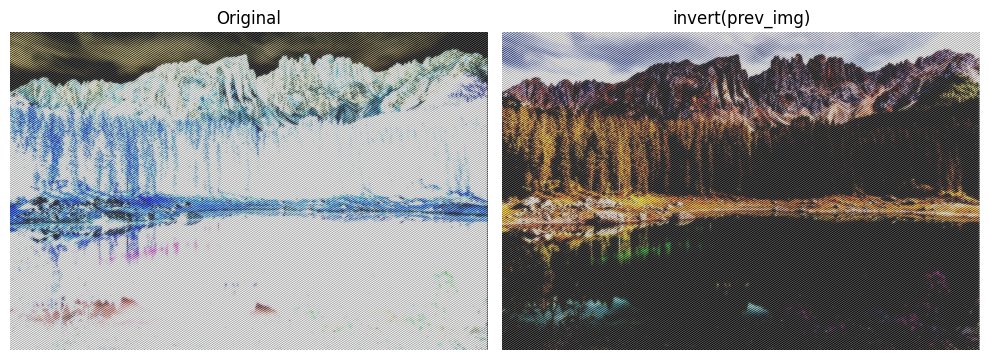

21
[(30, 202, 0), (30, 352, 0), (30, 52, 22), (30, 352, 30), (30, 201, 46), (30, 352, 60), (30, 202, 76), (30, 352, 90), (30, 202, 106), (30, 352, 120), (30, 202, 136), (30, 352, 150), (30, 202, 166), (30, 352, 180), (30, 202, 196), (30, 352, 210), (30, 202, 226), (30, 352, 240), (30, 202, 256), (30, 352, 270), (30, 202, 286)]


0it [00:00, ?it/s]


Notch Filters (1): 
	d0 = 30    x = 202   y = 0    
	d0 = 30    x = 803   y = 670   (Conjugation)


1it [00:01,  1.40s/it]


Notch Filters (2): 
	d0 = 30    x = 352   y = 0    
	d0 = 30    x = 653   y = 670   (Conjugation)


2it [00:02,  1.39s/it]


Notch Filters (3): 
	d0 = 30    x = 52    y = 22   
	d0 = 30    x = 953   y = 648   (Conjugation)


3it [00:04,  1.43s/it]


Notch Filters (4): 
	d0 = 30    x = 352   y = 30   
	d0 = 30    x = 653   y = 640   (Conjugation)


4it [00:05,  1.46s/it]


Notch Filters (5): 
	d0 = 30    x = 201   y = 46   
	d0 = 30    x = 804   y = 624   (Conjugation)


5it [00:07,  1.52s/it]


Notch Filters (6): 
	d0 = 30    x = 352   y = 60   
	d0 = 30    x = 653   y = 610   (Conjugation)


6it [00:08,  1.55s/it]


Notch Filters (7): 
	d0 = 30    x = 202   y = 76   
	d0 = 30    x = 803   y = 594   (Conjugation)


7it [00:10,  1.52s/it]


Notch Filters (8): 
	d0 = 30    x = 352   y = 90   
	d0 = 30    x = 653   y = 580   (Conjugation)


8it [00:11,  1.51s/it]


Notch Filters (9): 
	d0 = 30    x = 202   y = 106  
	d0 = 30    x = 803   y = 564   (Conjugation)


9it [00:13,  1.49s/it]


Notch Filters (10): 
	d0 = 30    x = 352   y = 120  
	d0 = 30    x = 653   y = 550   (Conjugation)


10it [00:14,  1.49s/it]


Notch Filters (11): 
	d0 = 30    x = 202   y = 136  
	d0 = 30    x = 803   y = 534   (Conjugation)


11it [00:16,  1.49s/it]


Notch Filters (12): 
	d0 = 30    x = 352   y = 150  
	d0 = 30    x = 653   y = 520   (Conjugation)


12it [00:17,  1.49s/it]


Notch Filters (13): 
	d0 = 30    x = 202   y = 166  
	d0 = 30    x = 803   y = 504   (Conjugation)


13it [00:19,  1.52s/it]


Notch Filters (14): 
	d0 = 30    x = 352   y = 180  
	d0 = 30    x = 653   y = 490   (Conjugation)


14it [00:20,  1.51s/it]


Notch Filters (15): 
	d0 = 30    x = 202   y = 196  
	d0 = 30    x = 803   y = 474   (Conjugation)


15it [00:22,  1.54s/it]


Notch Filters (16): 
	d0 = 30    x = 352   y = 210  
	d0 = 30    x = 653   y = 460   (Conjugation)


16it [00:24,  1.56s/it]


Notch Filters (17): 
	d0 = 30    x = 202   y = 226  
	d0 = 30    x = 803   y = 444   (Conjugation)


17it [00:25,  1.56s/it]


Notch Filters (18): 
	d0 = 30    x = 352   y = 240  
	d0 = 30    x = 653   y = 430   (Conjugation)


18it [00:27,  1.54s/it]


Notch Filters (19): 
	d0 = 30    x = 202   y = 256  
	d0 = 30    x = 803   y = 414   (Conjugation)


19it [00:28,  1.53s/it]


Notch Filters (20): 
	d0 = 30    x = 352   y = 270  
	d0 = 30    x = 653   y = 400   (Conjugation)


20it [00:30,  1.50s/it]


Notch Filters (21): 
	d0 = 30    x = 202   y = 286  
	d0 = 30    x = 803   y = 384   (Conjugation)


21it [00:31,  1.50s/it]


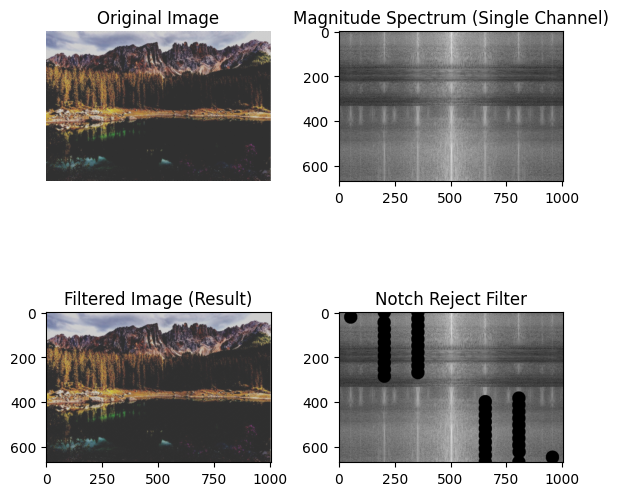

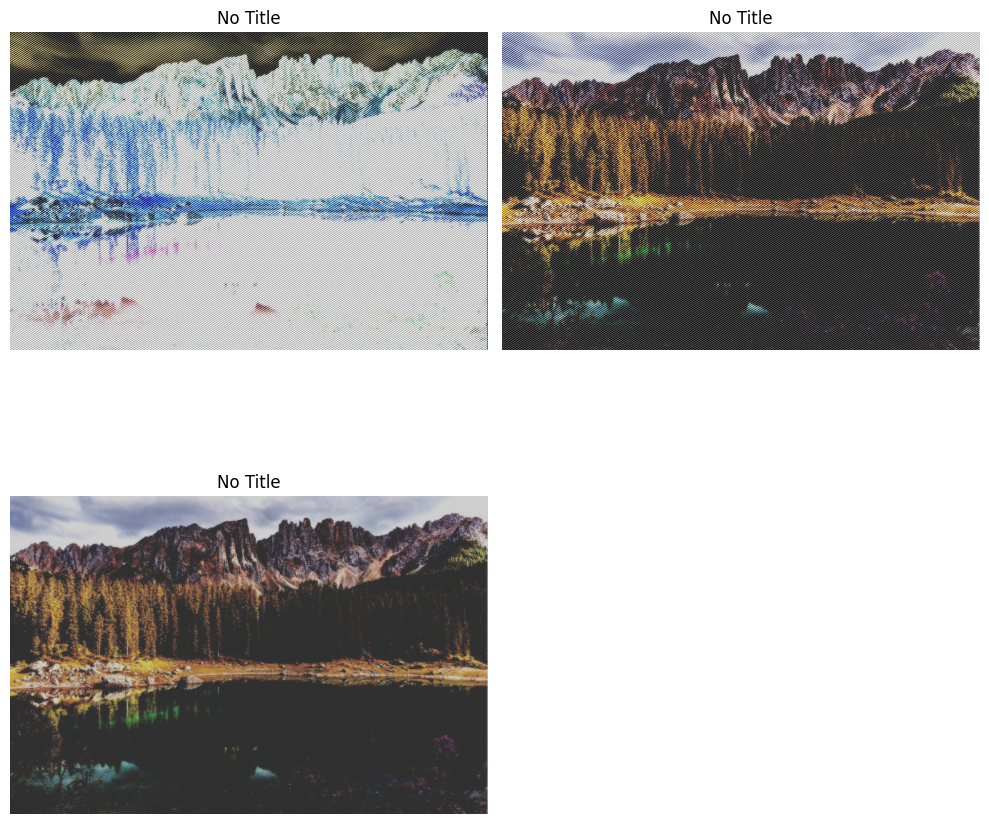

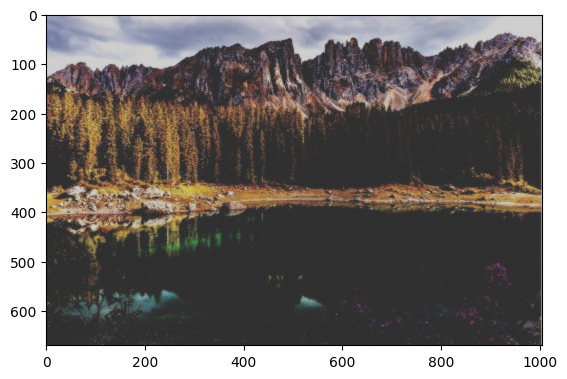

In [44]:
effects = [
            ["invert"],
            # ["adjust", "contrast=0.90", "brightness=20"],
            # ["median_filter", "kernel_size=5"],
        ]

cmaps = []
original_img = read_image("04_image.jpg")
process_images = process_image(original_img, effects=effects, cmaps=cmaps, img_scale=5)


# blur_kernel = motion_blur_kernel(1, 0, True)
# print(blur_kernel)
# plt.imshow(blur_kernel)
# img = wiener_filter(process_images[-1], kernel=blur_kernel)


notch_param = [
    # (30,200,40),
    # (30,360,190),
    # (30,100, 250),
    # (30,50, 570),
    # (30,500,350),
]

for i in notch_param:
    print(i)

notched_img = apply_notch_filters(process_images[-1], notch_param, auto=True, threshold=4.1, auto_d0=20)

imgs = [*process_images, notched_img]
show_images(2, 2, imgs, titles=[], scale=5)

plt.imshow(imgs[-1])

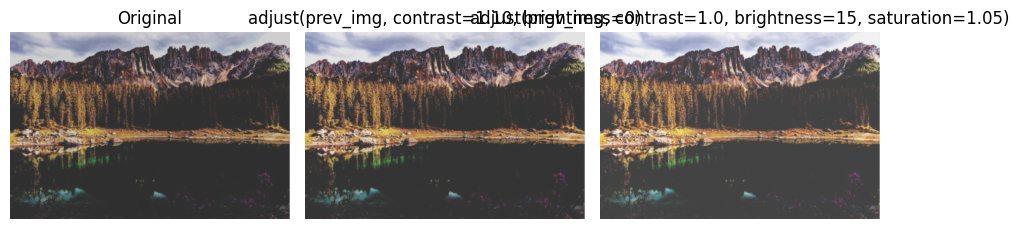

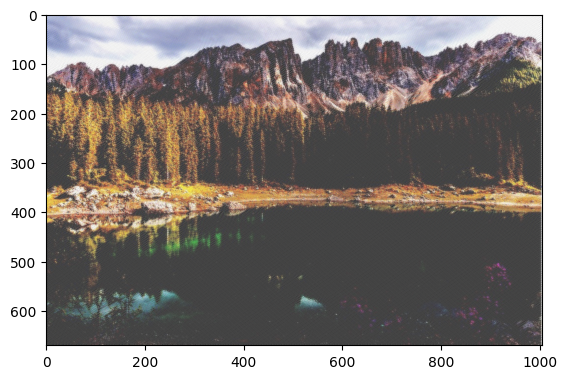

In [45]:

effects = [ 
            ["adjust", "contrast=1.10", "brightness=0"],
            ["adjust", "contrast=1.0", "brightness=15", "saturation=1.05"],
            # ["mean_filter", "kernel_size=5"],
            # ["median_filter", "kernel_size=5"],
            # ["erode", "kernel_size=2", "iterations=3"],
            # ["median_filter", "kernel_size=7"],
            # ["dilate", "kernel_size=2", "iterations=3"],
            # ["median_filter", "kernel_size=3"],
        ]
prev_images = imgs
prev_images = process_image(prev_images[-1], effects=effects, cmaps=cmaps, col=1)


plt.imshow(prev_images[-1])